# Transformer: A Novel [Google](https://ai.googleblog.com/2017/08/transformer-novel-neural-network.html) Language Understanding

In [1]:
import os
import time
import copy
import numpy as np
import pandas as pd
import pickle

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchtext import data

In [3]:
from utils import create_masks, show_plot_evaluation, translate_text

In [4]:
from Iterator import batch_size_fn, Iterator
from Tokenizer import Tokenizer
from Embedder import Embedder
from PositionalEncoder import PositionalEncoder
from Sublayers import Norm, MultiHeadedSelfAttention, FeedForward
from Layers import EncoderLayer, DecoderLayer
from Scheduler import CosineWithRestarts

## Set Configs

In [5]:
N_EPOCHS = 1 # 100
N_LAYERS = 6
N_HEADS = 8
D_MODEL = EMBEDDING_DIM = 512 # this can be the length of the longest sentence in our training dataset
MAX_LENGTH = 80

DROPOUT = 0.1
BATCH_SIZE = 1500
LR = 0.0001

BETA1 = 0.9
BETA2 = 0.98
EPS = 1e-9

In [6]:
is_cuda = torch.cuda.is_available()

if is_cuda: device = torch.device('cuda')
else: device = torch.device('cpu')

## Load Datasets

In [7]:
SOURCE_LANG = 'en_core_web_sm'
TARGET_LANG = "fr_core_news_sm"

SOURCE_DATA = open('./datasets/english.txt').read().strip().split('\n')
TARGET_DATA = open('./datasets/french.txt').read().strip().split('\n')

## Pre-process Datasets

In [8]:
token_source = Tokenizer(SOURCE_LANG)
token_target = Tokenizer(TARGET_LANG)

SOURCE_FIELD = data.Field(lower=True, tokenize=token_source.tokenize)
TARGET_FIELD = data.Field(lower=True, tokenize=token_target.tokenize, init_token='<SOS>', eos_token='<EOS>')

In [9]:
raw_data = {'SOURCE': [line for line in SOURCE_DATA], 'TARGET': [line for line in TARGET_DATA]}
df_datasets = pd.DataFrame(raw_data, columns=['SOURCE', 'TARGET'])
df_datasets.head()

,SOURCE,TARGET
0,Go.,Va !
1,Run!,Cours !
2,Run!,Courez !
3,Fire!,Au feu !
4,Help!,À l'aide !


In [10]:
mask = (df_datasets['SOURCE'].str.count(' ') < MAX_LENGTH) & (df_datasets['TARGET'].str.count(' ') < MAX_LENGTH)
df_datasets = df_datasets.loc[mask]

df_datasets.to_csv('./datasets/translate_transformer_temp.csv', index=False)
data_fields = [('SOURCE', SOURCE_FIELD), ('TARGET', TARGET_FIELD)]
train = data.TabularDataset('./datasets/translate_transformer_temp.csv', format='csv', fields=data_fields)
train_iter = Iterator(train, batch_size=BATCH_SIZE, device=device, repeat=False, 
                      sort_key=lambda x: (len(x.SOURCE), len(x.TARGET)),
                      batch_size_fn=batch_size_fn, train=True, shuffle=True)

In [11]:
SOURCE_FIELD.build_vocab(train)
TARGET_FIELD.build_vocab(train)

pickle.dump(SOURCE_FIELD, open('datasets/SOURCE.pkl', 'wb'))
pickle.dump(TARGET_FIELD, open('datasets/TARGET.pkl', 'wb'))

SOURCE_PAD = SOURCE_FIELD.vocab.stoi['<PAD>']
TARGET_PAD = TARGET_FIELD.vocab.stoi['<PAD>']

for i, b in enumerate(train_iter): 
    TRAIN_LENGTH = i
    pass

In [12]:
source_vocab_size = len(SOURCE_FIELD.vocab)
target_vocab_size = len(TARGET_FIELD.vocab)

## Build [Transformer](https://arxiv.org/pdf/1706.03762.pdf) Network

In [13]:
class Encoder(nn.Module):
    
    def __init__(self, vocab_size, heads, N, d_model, dropout):
        super(Encoder, self).__init__()
            
        # function for duplicating encoder layers
        def get_clones(module, N):
            return nn.ModuleList([copy.deepcopy(module) for i in range(N)])

        self.N = N
        self.embedding_layer = Embedder(vocab_size, d_model)
        self.pe = PositionalEncoder(d_model, dropout=dropout)
        self.encoder_layer = get_clones(EncoderLayer(heads, d_model, dropout), N)
        self.norm = Norm(d_model)
    
    def forward(self, source_seq, mask):
        
        source_seq = source_seq.to(device)
        
        x = self.embedding_layer(source_seq)
        x = self.pe(x)
        for i in range(self.N):
            x = self.encoder_layer[i](x, mask, device)
            
        x = self.norm(x)
        return x

In [14]:
class Decoder(nn.Module):
    
    def __init__(self, vocab_size, heads, N, d_model, dropout):
        super(Decoder, self).__init__()
        
        # function for duplicating decoder layers
        def get_clones(module, N):
            return nn.ModuleList([copy.deepcopy(module) for i in range(N)])
        
        self.N = N
        self.embedding_layer = Embedder(vocab_size, d_model)
        self.pe = PositionalEncoder(d_model, dropout=dropout)
        self.decoder_layer = get_clones(DecoderLayer(heads, d_model, dropout), N)
        self.norm = Norm(d_model)
        
    def forward(self, target_seq, encoder_outputs, source_mask, target_mask):
        
        target_seq = target_seq.to(device)
        
        x = self.embedding_layer(target_seq)
        x = self.pe(x)
        for i in range(self.N):
            x = self.decoder_layer[i](x, encoder_outputs, source_mask, target_mask, device)
            
        x = self.norm(x)
        return x

In [15]:
class Transformer(nn.Module):
    
    def __init__(self, source_vocab, target_vocab, heads, N, d_model, dropout):
        super(Transformer, self).__init__()
        
        self.encoder = Encoder(source_vocab, heads, N, d_model, dropout)
        self.decoder = Decoder(target_vocab, heads, N, d_model, dropout)
        self.output_layer = nn.Linear(d_model, target_vocab)
        
    # this transformer doesn't perform softmax on the output
    # the process will be handled automatically by our loss function
    def forward(self, source_seq, target_seq, source_mask, target_mask):
        
        encoder_outputs = self.encoder(source_seq, source_mask)
        decoder_output = self.decoder(target_seq, encoder_outputs, source_mask, target_mask)
        output = self.output_layer(decoder_output)
        
        return output

#### Initialize Transformer Network

In [16]:
transformer = Transformer(source_vocab_size, target_vocab_size, N_HEADS, N_LAYERS, D_MODEL, DROPOUT)
transformer.to(device)
for p in transformer.parameters(): 
    if p.dim() > 1: nn.init.xavier_uniform_(p)      

## Set Loss Function

In [17]:
def ce_loss(predictions, labels, ignore_index):
    
    loss = F.cross_entropy(predictions.view(-1, predictions.size(-1)), labels, ignore_index=ignore_index)
    return loss

## Set Optimizer

In [18]:
optimizer = torch.optim.Adam(transformer.parameters(), lr=LR, betas=(BETA1, BETA2), eps=EPS)

## Set Scheduler

In [19]:
scheduler = CosineWithRestarts(optimizer=optimizer, T_max=TRAIN_LENGTH)

## Train Transformer Network

In [20]:
temp = tick = time.time()

losses_history = []
print_every = 100

print('Training the network...')
transformer.train()

for epoch in range(1, N_EPOCHS+1):
    
    total_loss = 0
    for i, batch in enumerate(train_iter):
        
        source = batch.SOURCE.transpose(0,1)
        target = batch.TARGET.transpose(0,1)
        target_input = target[:, :-1] # the network produces the outputs one at a time
        source_mask, target_mask = create_masks(source, target_input, SOURCE_PAD, TARGET_PAD, device)
        
        optimizer.zero_grad()
        
        predictions = transformer(source, target_input, source_mask, target_mask)
        labels = target[:, 1:].contiguous().view(-1)
        loss = ce_loss(predictions, labels, ignore_index=TARGET_PAD)
        
        loss.backward()
        optimizer.step()
        scheduler.step()
        
        total_loss += loss.item()
        
        if i % print_every == 0:
            p = int(100 * i / TRAIN_LENGTH)
            avg_loss = total_loss/ print_every
            print('Time: %dm, Epoch: %d [%s%s] %d%%, Loss = %.3f' %\
                  ((time.time() - tick)//60, epoch, ''.join('#'*(p//5)), ''.join(' '*(20-(p//5))), p, avg_loss), end='\r')
            
            total_loss = 0
    
    # plot average loss for evaluation
    losses_history.append(avg_loss)
    print('Time: %dm, Epoch: %d [%s%s] %d%%, Loss = %.3f\nEpoch %d complete, Loss: %.03f' %\
        ((time.time() - tick)//60, epoch, ''.join('#'*(100//5)), ''.join(' '*(20-(100//5))), 100, avg_loss, epoch, avg_loss))
          
    # save models per each epoch
    if not os.path.exists('./weights/'): os.makedirs('./weights/')
    torch.save(transformer.state_dict(), 'weights/transformer.hdf5')
    

Training the network...
Time: 222m, Epoch: 1 [####################] 100%, Loss = 5.104
Epoch 1 complete, Loss: 5.104


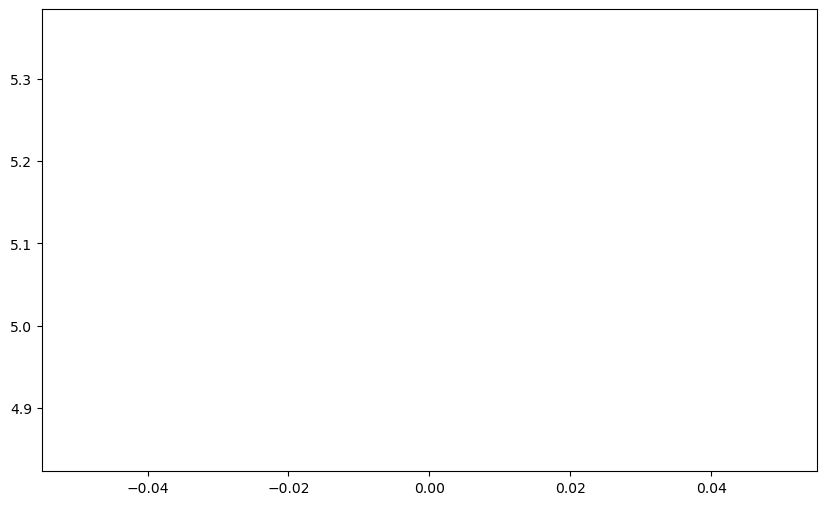

In [ ]:
show_plot_evaluation(losses_history, 1)

## Evaluate The Network

In [22]:
text = 'what are you thinking?'

phrase = translate_text(text, transformer, SOURCE_FIELD, TARGET_FIELD, MAX_LENGTH, device)
print('> ' + phrase + '\n')

> Tu tu vous tu vous



In [23]:
text = 'i love artificial intelligence'

phrase = translate_text(text, transformer, SOURCE_FIELD, TARGET_FIELD, MAX_LENGTH, device)
print('> ' + phrase + '\n')

> J'j'ai..



In [24]:
text = 'you are wonderful!'

phrase = translate_text(text, transformer, SOURCE_FIELD, TARGET_FIELD, MAX_LENGTH, device)
print('> ' + phrase + '\n')

> Vous vous vous vous.



In [25]:
text = 'for the brighter future!'

phrase = translate_text(text, transformer, SOURCE_FIELD, TARGET_FIELD, MAX_LENGTH, device)
print('> ' + phrase + '\n')

> ...



In [26]:
text = 'If we wanted to travel around the world, could we buy the tickets tomorrow?'

phrase = translate_text(text, transformer, SOURCE_FIELD, TARGET_FIELD, MAX_LENGTH, device)
print('> ' + phrase + '\n')

> Il il il il il,,,,,,,,,



---